# Weather Model

## Directions

For this project, you will need to implement a filtering  inference task on an HMM. These are described in Section 15.2 of the text.

Denote the hidden states of the HMM by `S(t)` and the observations (evidence) by `E(t)`. In the weather problem from the HMM Tutorial, X(t) would be either sunny, rainy, or foggy, and `E(t)` is yes or no to indicate if an umbrella was observed. We will use this model with prior probabilities P(sunny) = 0.5, P(rainy) = 0.25, P(foggy) = 0.25. The remaining probilities you need are specified below in the emisssion (`P_emission`) and transition matrices (`P_transition`).

## What you need to do

You will need to fill in the missing implementations of the following functions in the code where specified by the comments (`### YOUR CODE HERE ###`) and answer the questions where indicated.

In implementing the code for the filtering task, you will be computing the probability of rain given the observations of the umbrella.

## Probability Definitions
Below you will find:
- `P_init`: The initial probabilities of the weather state, whether sunny (0), rainy (1) or foggy (2)
- `P_transition`: The transition probabilities or the probability that one weather state one day transitions to another weather state
- `P_emission`: The 'emission' probabilities or the probabilities that an observation is made, conditioned on the underlying state.

In [1]:
### DO NOT CHANGE ###

import numpy as np

# prior probability on weather states
# P(sunny) = 0.5  P(rainy) = 0.25  P(foggy) = 0.25
P_init = np.array([0.5, 0.25, 0.25])

# states (0=sunny, 1=rainy, 2=foggy)
S = [0, 1, 2]

# transition probabilities
#                    tomorrrow
#    today     sunny  rainy  foggy
#    sunny      0.8    0.05   0.15
#    rainy      0.2    0.6    0.2
#    foggy      0.2    0.3    0.5
P_transition = np.array([ [0.8, 0.05, 0.15], [0.2, 0.6, 0.2], [0.2, 0.3, 0.5] ])

# conditional probabilities of evidence (observations) given weather
#                            sunny  rainy  foggy
# P(weather | umbrella=no)    0.9    0.2    0.7
# P(weather | umbrella=yes)   0.1    0.8    0.3
P_emission = np.array([ [0.9, 0.2, 0.7], [0.1, 0.8, 0.3] ])

### [Question - State Transitions]
If today is sunny what is the most likely forecast for the next two days if you have no umbrella observations to work with?

In [11]:
print(f"If today is sunny, the most likely forecast for the next two days is: "
      f"{['Sunny', 'Rainy', 'Foggy'][np.argmax(P_transition[0])]} on the next day, and "
      f"{['Sunny', 'Rainy', 'Foggy'][np.argmax(P_transition[np.argmax(P_transition[0])])]} on the day after.") ##Reference: https://stackoverflow.com/questions/9482550/argmax-of-numpy-array-returning-non-flat-indices/9482667

If today is sunny, the most likely forecast for the next two days is: Sunny on the next day, and Sunny on the day after.


### [Question - Emission probabilities ]
If on the first day you see no umbrella, what is the probability that it is rainy, foggy or sunny (Hint: remember the importance of overall probability of each state)?

What is the most likely weather (hidden state)?

In [12]:
P_state_day0_given_umbrella = P_emission[0] * P_init
P_state_day0_given_umbrella /= np.sum(P_state_day0_given_umbrella)
print(f"The probabilities are: Sunny = {P_state_day0_given_umbrella[0]:.2f}, "
      f"Rainy = {P_state_day0_given_umbrella[1]:.2f}, Foggy = {P_state_day0_given_umbrella[2]:.2f}. "
      f"The most likely weather on the first day is {'Sunny' if np.argmax(P_state_day0_given_umbrella) == 0 else 'Rainy' if np.argmax(P_state_day0_given_umbrella) == 1 else 'Foggy'}.")
##Reference: https://stackoverflow.com/questions/75877816/normalizing-numpy-array-sum-to-1-0-fails-on-intel-cpu-and-also-colab?noredirect=1&lq=1

The probabilities are: Sunny = 0.67, Rainy = 0.07, Foggy = 0.26. The most likely weather on the first day is Sunny.


### Evidence / observations

Now we will define the observations on each day - whether we observed an umbrella (1) or not (0).


In [6]:
### DO NOT CHANGE ###

## 0 = no umbrella, 1 = umbrella
E = [0, 0, 0, 1, 0, 0, 1, 1, 0, 1]

## Filtering

*As a reminder*

**Filtering**:
Given observation sequence E(0), E(1), ..., E(T-1), compute P(X(T-1)|E(0), ..., E(T-1)).

So we are computing the probability of the final state given our observations or evidence to date.

We do this with the *Forward Algorithm* (see 15.2 in the text), which requires that we initialize probabilities at the first step using our 'prior' probability values of each underlying state. Then we update probabilities at each step (`Recursion`) using the prior step probabilities and given new evidence. We do this until we reach the end and then compute the total probability of each underlying state at the finel step.

### Recursion (and initialization) function definition

In [7]:
### DO NOT CHANGE ###

# Normalize a probability distribution
def normalize(pdist):
   s = sum(pdist)
   for i in range(0,len(pdist)):
      pdist[i] = pdist[i] / s
   return pdist

DEBUG=True

def init_and_recursion(Obs, S, init_prob, P_emission, P_transition):
  ## a has a "row" for every observation and a "column" for every possible state
  a = np.zeros((len(Obs), len(S)))
  for t in range(0, len(Obs)):
    print(f".. (time {t}) Observation: {Obs[t]}")
    ## probability of a[0,:] is computed by summing over probabilities of all the
    ## ways we could get to this "path" given where we left off at the previous
    ## time step
    if t == 0:
      ##### Initialization
      for j in range(len(S)):
        #print(f"t={t}, j={j}, S[j]={S[j]}, Obs[t]={Obs[t]}")
        a[t, j] = init_prob[j] * P_emission[Obs[t], S[j]]
        current_state_total_prob = a[t, j]
        print(f".... Probability at state {S[j]}: {current_state_total_prob:.4f} (initial state)")
    else:
      ## we need to compute a probability for each of the possible states
      for j in range(len(S)): ## for each of the present states
        S_curr = S[j]
        ## we need to sum over all of the previous states to get current state prob
        ## we'll keep track of that probability to sum up here
        current_state_total_prob = 0.0
        for k in range(len(S)): ## for each of the possible previous states
          S_prev = S[k] ## possible previous state that we came from
          if DEBUG:
            print(f"......Transition from state={S_prev} to state={S_prev}")
            print(f"        Calculation: ")
            print(f"        {a[t-1, k]:.2f} * {P_emission[Obs[t], S[j]]:.2f} * {P_transition[S_prev, S_curr]:.2f}")
          current_state_total_prob += a[t-1, k] * P_emission[Obs[t], S[j]] * P_transition[S_prev, S_curr]
        a[t, j] = current_state_total_prob
    a[t,:] = normalize(a[t,:])
    print(f".... State probabilities: {a[t, :]}")
  return a

### Termination function definition

In [8]:
### DO NOT CHANGE ###

def termination(a):
  total_ending_prob = 0
  T = a.shape[0]-1 ## last time point
  for i in range(len(a[T, :])):
    total_ending_prob += a[T, i]
  print(f"\nProbability of each potential state: {a[T]}")

### [Question - Final state]
What is the most likely final state (most likely weather)? How much more likely is the final weather than the other two options?

Use the above recursion and initialization function to compute the most likely state at the end (the filtering problem).

In [9]:
import numpy as np

# Example of state space and initial probabilities
S = ['Sunny', 'Rainy', 'Foggy']  # States
init_prob = np.array([0.5, 0.25, 0.25])  # Initial probabilities (sunny, rainy, foggy)

# Example of emission and transition probabilities
P_emission = np.array([
    [0.9, 0.2, 0.7],  # P(umbrella = no | sunny, rainy, foggy)
    [0.1, 0.8, 0.3]   # P(umbrella = yes | sunny, rainy, foggy)
])

P_transition = np.array([
    [0.8, 0.05, 0.15],  # sunny -> sunny, rainy, foggy
    [0.2, 0.6, 0.2],    # rainy -> sunny, rainy, foggy
    [0.2, 0.3, 0.5]     # foggy -> sunny, rainy, foggy
])

# Observations (0 = no umbrella, 1 = umbrella)
E = [0, 0, 0, 1, 0, 0, 1, 1, 0, 1]

# Normalize probability distribution
def normalize(pdist):
    s = sum(pdist)
    for i in range(0, len(pdist)):
        pdist[i] = pdist[i] / s
    return pdist

# Recursion and initialization function
def init_and_recursion(Obs, S, init_prob, P_emission, P_transition):
    a = np.zeros((len(Obs), len(S)))
    for t in range(0, len(Obs)):
        print(f".. (time {t}) Observation: {Obs[t]}")
        if t == 0:
            for j in range(len(S)):
                a[t, j] = init_prob[j] * P_emission[Obs[t], j]
                print(f".... Probability at state {S[j]}: {a[t, j]:.4f} (initial state)")
        else:
            for j in range(len(S)):
                current_state_total_prob = 0.0
                for k in range(len(S)):
                    current_state_total_prob += a[t-1, k] * P_emission[Obs[t], j] * P_transition[k, j]
                a[t, j] = current_state_total_prob
        a[t,:] = normalize(a[t,:])
        print(f".... State probabilities: {a[t, :]}")
    return a

# Forward algorithm
a = init_and_recursion(E, S, init_prob, P_emission, P_transition)

# Most likely final state
final_state_probs = a[-1]
most_likely_state_index = np.argmax(final_state_probs)
most_likely_state = S[most_likely_state_index]
print(f"Most likely final state: {most_likely_state} with probability {final_state_probs[most_likely_state_index]:.4f}")

# How much more likely the final state is compared to the other states
other_states_probs = np.delete(final_state_probs, most_likely_state_index)
most_likely_difference = final_state_probs[most_likely_state_index] - np.max(other_states_probs)
print(f"The most likely final weather is {most_likely_state}, and it is {most_likely_difference:.4f} more likely than the other options.")

.. (time 0) Observation: 0
.... Probability at state Sunny: 0.4500 (initial state)
.... Probability at state Rainy: 0.0500 (initial state)
.... Probability at state Foggy: 0.1750 (initial state)
.... State probabilities: [0.66666667 0.07407407 0.25925926]
.. (time 1) Observation: 0
.... State probabilities: [0.72754491 0.04191617 0.23053892]
.. (time 2) Observation: 0
.... State probabilities: [0.75184188 0.03430323 0.21385489]
.. (time 3) Observation: 1
.... State probabilities: [0.28193177 0.42375772 0.29431051]
.. (time 4) Observation: 0
.... State probabilities: [0.557914   0.11977787 0.32230813]
.. (time 5) Observation: 0
.... State probabilities: [0.67907217 0.05543917 0.26548866]
.. (time 6) Observation: 1
.... State probabilities: [0.24110328 0.46633912 0.2925576 ]
.. (time 7) Observation: 1
.... State probabilities: [0.08189068 0.72158412 0.1965252 ]
.. (time 8) Observation: 0
.... State probabilities: [0.44681054 0.19767926 0.3555102 ]
.. (time 9) Observation: 1
.... State pr

### [Question - Plot probabilities ]

Use the [PyPlot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html#:~:text=the%20pyplot%20interface.-,Intro%20to%20pyplot,the%20plot%20with%20labels%2C%20etc.) library to plot the transition probabilities over time.

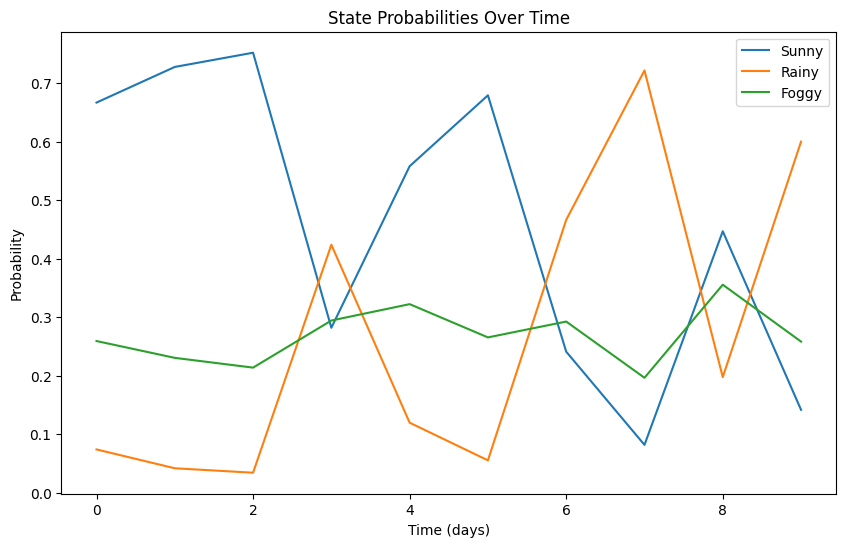

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Example state space and initial probabilities
S = ['Sunny', 'Rainy', 'Foggy']  # States
init_prob = np.array([0.5, 0.25, 0.25])  # Initial probabilities (sunny, rainy, foggy)

# Example emission and transition probabilities
P_emission = np.array([
    [0.9, 0.2, 0.7],  # P(umbrella = no | sunny, rainy, foggy)
    [0.1, 0.8, 0.3]   # P(umbrella = yes | sunny, rainy, foggy)
])

P_transition = np.array([
    [0.8, 0.05, 0.15],  # sunny -> sunny, rainy, foggy
    [0.2, 0.6, 0.2],    # rainy -> sunny, rainy, foggy
    [0.2, 0.3, 0.5]     # foggy -> sunny, rainy, foggy
])

# Observations (0 = no umbrella, 1 = umbrella)
E = [0, 0, 0, 1, 0, 0, 1, 1, 0, 1]

# Normalize probability distribution
def normalize(pdist):
    s = sum(pdist)
    for i in range(0, len(pdist)):
        pdist[i] = pdist[i] / s
    return pdist

# Recursion and initialization function
def init_and_recursion(Obs, S, init_prob, P_emission, P_transition):
    a = np.zeros((len(Obs), len(S)))
    for t in range(0, len(Obs)):
        if t == 0:
            for j in range(len(S)):
                a[t, j] = init_prob[j] * P_emission[Obs[t], j]
        else:
            for j in range(len(S)):
                current_state_total_prob = 0.0
                for k in range(len(S)):
                    current_state_total_prob += a[t-1, k] * P_emission[Obs[t], j] * P_transition[k, j]
                a[t, j] = current_state_total_prob
        a[t,:] = normalize(a[t,:])
    return a

# Forward algorithm
a = init_and_recursion(E, S, init_prob, P_emission, P_transition)

# Plot of the probabilities of each state over time
plt.figure(figsize=(10, 6))
plt.plot(a[:, 0], label='Sunny')
plt.plot(a[:, 1], label='Rainy')
plt.plot(a[:, 2], label='Foggy')
plt.xlabel('Time (days)')
plt.ylabel('Probability')
plt.title('State Probabilities Over Time')
plt.legend()
plt.show()